
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

BUT RIGHT NOW I'VE GOT A BUG SOMEWHERE: balance !=0 doesn't work when num_files > 1. I've got an index problem.

So you can run with multiple variables files only when balance=0, or you can run with only one variable file and set balance how you like.

In [1]:
# load libraries
# %pip install mlxtend

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
start_time = dt.datetime.now()

In [4]:
df=pd.read_csv('vars.csv')
df.head(5)

,Unnamed: 0,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,...,ssn_name_dob_unique_count_for_ssn_name_7,ssn_name_dob_unique_count_for_ssn_name_14,ssn_name_dob_unique_count_for_ssn_name_30,ssn_name_dob_unique_count_for_ssn_name_60,ssn_name_dob_unique_count_for_ssn_fulladdress_1,ssn_name_dob_unique_count_for_ssn_fulladdress_3,ssn_name_dob_unique_count_for_ssn_fulladdress_7,ssn_name_dob_unique_count_for_ssn_fulladdress_14,ssn_name_dob_unique_count_for_ssn_fulladdress_30,ssn_name_dob_unique_count_for_ssn_fulladdress_60
0,0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,000000-1,1797504115,...,1,1,1,1,1,1,1,1,1,1
1,1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,...,1,1,1,1,1,1,1,1,1,1
2,2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,...,1,1,1,1,1,1,1,1,1,1
3,3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,...,1,1,1,1,1,1,1,1,1,1
4,4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,...,1,1,1,1,1,1,1,1,1,1


In [6]:
# set some parameters
num_files = 1
num_filter = 100
num_wrapper = 30
# keep balance = 0 when num_files > 1 until I figure out this bug. Maybe somebody else can figure it out.
balance = 0
detect_rate = .03
index_name = 'record'
y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [8]:
%%time
for i in range(num_files):
    file_name= 'vars.csv'
    df = pd.read_csv('vars.csv', index_col=0)
    print('work on file ', file_name)
    df = df[df[index_name] <= 833508] # remove the last two months as the out-of-time data (OOT)
    df = df[df[index_name] >= 38512] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods.set_index(index_name, inplace=True)
            goods.sort_index(inplace=True)
            goods = goods.iloc[goods_keep] # THERE'S SOMETHING WRONG HERE AND I CAN'T FIGURE IT OUT
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.set_index(index_name, inplace=True)
    df_sampled.sort_index(inplace=True)
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
        filter_score.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            filter_score.loc[j,'variable'] = column
            filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
            
        filter_score.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(filter_score['variable'][1:num_filter+1])
        print(filter_score.head(num_filter))
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        new = pd.DataFrame(np.zeros((num_vars+1,2)))
        new.columns = ['variable','score']   
        j = 0
        for column in df_sampled:
            new.loc[j,'variable'] = column
            new.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
            j = j+1
        
        new.sort_values(by=['score'], ascending=False, inplace=True)
        vars_keep = list(new['variable'][1:num_filter+1])
        print(new.head(num_filter))
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)
        filter_score = pd.concat([filter_score,new])
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()

work on file  vars.csv
                           variable     score
8                       fraud_label  1.000000
36                address_day_since  0.334096
64            fulladdress_day_since  0.333210
42                 address_count_30  0.332725
70             fulladdress_count_30  0.332032
..                              ...       ...
162              ssn_name_day_since  0.225389
168               ssn_name_count_30  0.224987
104  fulladdress_homephone_count_14  0.218906
198           address_count_1_by_30  0.218397
230       fulladdress_count_1_by_30  0.216304

[100 rows x 2 columns]
CPU times: user 5min 12s, sys: 3min 12s, total: 8min 24s
Wall time: 14min 19s


In [9]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)

In [10]:
filter_score.head(30)

,variable,score
8,fraud_label,1.000000
36,address_day_since,0.334096
64,fulladdress_day_since,0.333210
42,address_count_30,0.332725
70,fulladdress_count_30,0.332032
41,address_count_14,0.322252
69,fulladdress_count_14,0.321756
40,address_count_7,0.301445
68,fulladdress_count_7,0.301368
194,address_count_0_by_30,0.291997


In [11]:
filter_score.tail(10)

,variable,score
1010,ssn_name_dob_unique_count_for_ssn_name_14,0.0
1011,ssn_name_dob_unique_count_for_ssn_name_30,0.0
1012,ssn_name_dob_unique_count_for_ssn_name_60,0.0
608,fulladdress_dob_unique_count_for_fulladdress_14,0.0
607,fulladdress_dob_unique_count_for_fulladdress_7,0.0
606,fulladdress_dob_unique_count_for_fulladdress_3,0.0
605,fulladdress_dob_unique_count_for_fulladdress_1,0.0
782,ssn_zip5_unique_count_for_ssn_14,0.0
781,ssn_zip5_unique_count_for_ssn_7,0.0
779,ssn_zip5_unique_count_for_ssn_1,0.0


In [12]:
filter_score.shape

(1020, 2)

In [13]:
filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['address_day_since', 'fulladdress_day_since', 'address_count_30', 'fulladdress_count_30', 'address_count_14', 'fulladdress_count_14', 'address_count_7', 'fulladdress_count_7', 'address_count_0_by_30', 'fulladdress_count_0_by_30', 'fulladdress_unique_count_for_dob_homephone_60', 'fulladdress_unique_count_for_ssn_name_60', 'fulladdress_unique_count_for_ssn_lastname_60', 'fulladdress_unique_count_for_ssn_60', 'fulladdress_unique_count_for_ssn_zip5_60', 'fulladdress_unique_count_for_ssn_fulladdress_60', 'fulladdress_unique_count_for_ssn_name_dob_60', 'fulladdress_unique_count_for_name_fulladdress_60', 'fulladdress_unique_count_for_name_dob_60', 'fulladdress_unique_count_for_fulladdress_dob_60', 'fulladdress_unique_count_for_dob_homephone_30', 'fulladdress_unique_count_for_ssn_name_30', 'fulladdress_unique_count_for_ssn_lastname_30', 'fulladdress_unique_count_for_ssn_30', 'fulladdress_unique_count_for_ssn_zip5_30', 'fulladdress_unique_count_for_ssn_fulladdress_30', 'address_c

In [14]:
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,address_day_since,fulladdress_day_since,address_count_30,fulladdress_count_30,address_count_14,fulladdress_count_14,address_count_7,fulladdress_count_7,address_count_0_by_30,fulladdress_count_0_by_30,...,ssn_lastname_day_since,ssn_name_dob_count_30,ssn_firstname_count_30,ssn_lastname_count_30,ssn_name_day_since,ssn_name_count_30,fulladdress_homephone_count_14,address_count_1_by_30,fulladdress_count_1_by_30,name_dob_count_14
record,,,,,,,,,,,,,,,,,,,,,
38512,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38513,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38514,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38515,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1
38516,365.0,365.0,1,1,1,1,1,1,30.0,30.0,...,365.0,1,1,1,365.0,1,1,30.0,30.0,1


In [15]:
df_keep.shape

(794997, 100)

In [16]:
Y.head()

,fraud_label
record,
38512,0
38513,0
38514,0
38515,0
38516,0


In [17]:
Y = Y.values
X = df_keep

In [18]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 1:24:46.857394


In [19]:
print(X.shape,Y.shape)

(794997, 100) (794997, 1)


In [15]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [20]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [21]:
%%time
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
clf = RandomForestClassifier(n_estimators=5, n_jobs=-1) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished

[2022-02-28 21:07:39] Features: 1/30 -- score: 0.35425735678216963[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:  4.6min finished

[2022-02-28 21:12:17] Features: 2/30 -- score: 0.5195020024377504[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  5.1min finished

[2022-02-28 21:17:25] Features: 3/30 -- score: 0.5212432526554065[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 out 

CPU times: user 2min 31s, sys: 5min 25s, total: 7min 57s
Wall time: 2h 44min 18s


SequentialFeatureSelector(cv=2,
                          estimator=RandomForestClassifier(n_estimators=5,
                                                           n_jobs=-1),
                          k_features=30, n_jobs=-1,
                          scoring=<function fdr at 0x7fb8c59e1670>, verbose=2)

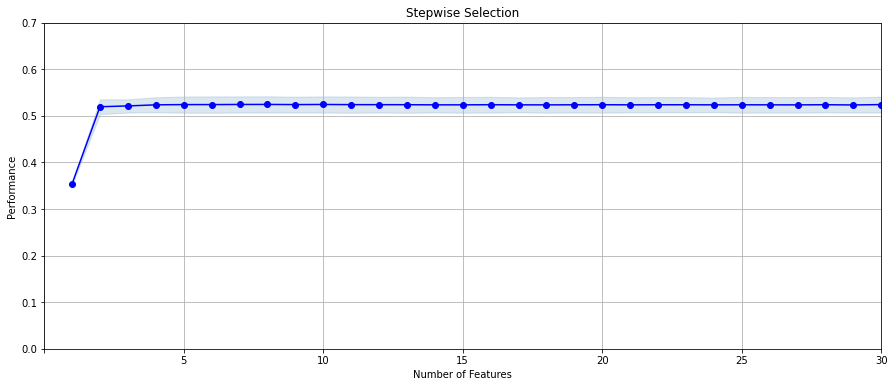

In [22]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.ylim([0., .7])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [23]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.351732543966568, 0.3567821695977712]",0.354257,"(fulladdress_count_30,)",0.010863,0.002525,0.002525
2,"(3, 83)","[0.5035695629461954, 0.5354344419293052]",0.519502,"(fulladdress_count_30, ssn_dob_count_30)",0.068552,0.015932,0.015932
3,"(3, 10, 83)","[0.5070520633815079, 0.5354344419293052]",0.521243,"(fulladdress_count_30, fulladdress_unique_coun...",0.06106,0.014191,0.014191
4,"(3, 8, 10, 83)","[0.5074003134250392, 0.5397875674734459]",0.523594,"(fulladdress_count_30, address_count_0_by_30, ...",0.069676,0.016194,0.016194
5,"(3, 8, 10, 48, 83)","[0.5067038133379766, 0.5415288176911022]",0.524116,"(fulladdress_count_30, address_count_0_by_30, ...",0.07492,0.017413,0.017413
6,"(3, 8, 10, 30, 48, 83)","[0.506529688316211, 0.5417029427128678]",0.524116,"(fulladdress_count_30, address_count_0_by_30, ...",0.075669,0.017587,0.017587
7,"(3, 8, 10, 18, 30, 48, 83)","[0.5070520633815079, 0.5417029427128678]",0.524378,"(fulladdress_count_30, address_count_0_by_30, ...",0.074545,0.017325,0.017325
8,"(3, 8, 10, 16, 18, 30, 48, 83)","[0.5070520633815079, 0.5418770677346335]",0.524465,"(fulladdress_count_30, address_count_0_by_30, ...",0.07492,0.017413,0.017413
9,"(3, 8, 9, 10, 16, 18, 30, 48, 83)","[0.5070520633815079, 0.5411805676475709]",0.524116,"(fulladdress_count_30, address_count_0_by_30, ...",0.073422,0.017064,0.017064
10,"(3, 8, 9, 10, 16, 18, 30, 48, 49, 83)","[0.5070520633815079, 0.5417029427128678]",0.524378,"(fulladdress_count_30, address_count_0_by_30, ...",0.074545,0.017325,0.017325


In [24]:
vars_final = list(vars_FS.loc[num_wrapper, 'feature_names'])
vars_final

['address_count_30',
 'fulladdress_count_30',
 'fulladdress_count_14',
 'address_count_0_by_30',
 'fulladdress_count_0_by_30',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_60',
 'fulladdress_unique_count_for_ssn_name_dob_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_ssn_30',
 'fulladdress_unique_count_for_ssn_zip5_30',
 'fulladdress_unique_count_for_ssn_fulladdress_30',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_dob_homephone_14',
 'fulladdress_unique_count_for_ssn_name_14',
 'fulladdress_unique_count_for_ssn_lastname_14',
 'fulladdress_unique_count_for_ssn_name_dob_14',
 'fulladdress_unique_count_for_name_fulladdress_14',
 'fulladdress_unique_count_for_name_dob_14',
 'fulladdress_unique_count_for_fulladdress_dob_14',
 'fulladdress_unique_count_for_dob_homephone_7',
 'fulladdress_unique_count_for_ssn_lastname_7',
 'fulladdress_uniq

In [25]:
vars_FS.to_csv('VarsFS.csv', index=False)

In [26]:
sfs.subsets_

{1: {'feature_idx': (3,),
  'cv_scores': array([0.35173254, 0.35678217]),
  'avg_score': 0.35425735678216963,
  'feature_names': ('fulladdress_count_30',)},
 2: {'feature_idx': (3, 83),
  'cv_scores': array([0.50356956, 0.53543444]),
  'avg_score': 0.5195020024377504,
  'feature_names': ('fulladdress_count_30', 'ssn_dob_count_30')},
 3: {'feature_idx': (3, 10, 83),
  'cv_scores': array([0.50705206, 0.53543444]),
  'avg_score': 0.5212432526554065,
  'feature_names': ('fulladdress_count_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 4: {'feature_idx': (3, 8, 10, 83),
  'cv_scores': array([0.50740031, 0.53978757]),
  'avg_score': 0.5235939404492426,
  'feature_names': ('fulladdress_count_30',
   'address_count_0_by_30',
   'fulladdress_unique_count_for_dob_homephone_60',
   'ssn_dob_count_30')},
 5: {'feature_idx': (3, 8, 10, 48, 83),
  'cv_scores': array([0.50670381, 0.54152882]),
  'avg_score': 0.5241163155145394,
  'feature_names': ('fulladdress_coun

In [27]:
vars_final.append('index_name')
vars_final.append('y_name')
vars_final

['address_count_30',
 'fulladdress_count_30',
 'fulladdress_count_14',
 'address_count_0_by_30',
 'fulladdress_count_0_by_30',
 'fulladdress_unique_count_for_dob_homephone_60',
 'fulladdress_unique_count_for_ssn_lastname_60',
 'fulladdress_unique_count_for_ssn_60',
 'fulladdress_unique_count_for_ssn_name_dob_60',
 'fulladdress_unique_count_for_name_dob_60',
 'fulladdress_unique_count_for_ssn_30',
 'fulladdress_unique_count_for_ssn_zip5_30',
 'fulladdress_unique_count_for_ssn_fulladdress_30',
 'fulladdress_unique_count_for_name_dob_30',
 'fulladdress_unique_count_for_dob_homephone_14',
 'fulladdress_unique_count_for_ssn_name_14',
 'fulladdress_unique_count_for_ssn_lastname_14',
 'fulladdress_unique_count_for_ssn_name_dob_14',
 'fulladdress_unique_count_for_name_fulladdress_14',
 'fulladdress_unique_count_for_name_dob_14',
 'fulladdress_unique_count_for_fulladdress_dob_14',
 'fulladdress_unique_count_for_dob_homephone_7',
 'fulladdress_unique_count_for_ssn_lastname_7',
 'fulladdress_uniq

In [28]:
X_final = df_keep.filter(vars_final, axis=1)
X_final.shape

(794997, 30)

In [29]:
X_final.to_csv('vars_final.csv', index=False)

In [30]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 4:10:52.048194
